<a href="https://colab.research.google.com/github/asyraffff/eICU-UMMC-Length-Of-Stay-Prediction/blob/main/4_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import KNNImputer
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, SimpleRNN, LSTM, GRU, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

# import warning library to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option("display.max_rows", None)

In [ ]:
df_cardiac_ed = pd.read_csv("drive/My Drive/FYP_LOS/dataset/cardiac_ed.csv", low_memory=False)
df_cardiac_ed_no_outliers = pd.read_csv("drive/My Drive/FYP_LOS/dataset/cardiac_ed_no_outliers.csv", low_memory=False)
df_cardiac_ed_quantile = pd.read_csv("drive/My Drive/FYP_LOS/dataset/cardiac_ed_quantile.csv", low_memory=False)

df_ppum = pd.read_csv("drive/My Drive/FYP_LOS/dataset/cardiac_ed_ppum.csv", low_memory=False)

In [ ]:
df_ppum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            20 non-null     int64  
 1   age               20 non-null     float64
 2   diagnosis_code    20 non-null     int64  
 3   LOS               20 non-null     float64
 4   intubated         20 non-null     float64
 5   wbc               20 non-null     float64
 6   respiratoryrate   20 non-null     float64
 7   heartrate         20 non-null     float64
 8   sodium            20 non-null     float64
 9   meanbp            20 non-null     float64
 10  hematocrit        20 non-null     float64
 11  creatinine        20 non-null     float64
 12  bun               20 non-null     float64
 13  glucose           20 non-null     float64
 14  thrombolytics     20 non-null     float64
 15  metastaticcancer  20 non-null     float64
 16  cirrhosis         20 non-null     float64
 17 

In [ ]:
df_cardiac_ed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13801 entries, 0 to 13800
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            13801 non-null  int64  
 1   age               13801 non-null  float64
 2   diagnosis_code    13801 non-null  int64  
 3   LOS               13801 non-null  float64
 4   intubated         13801 non-null  float64
 5   wbc               13801 non-null  float64
 6   respiratoryrate   13801 non-null  float64
 7   heartrate         13801 non-null  float64
 8   sodium            13801 non-null  float64
 9   meanbp            13801 non-null  float64
 10  hematocrit        13801 non-null  float64
 11  creatinine        13801 non-null  float64
 12  bun               13801 non-null  float64
 13  glucose           13801 non-null  float64
 14  thrombolytics     13801 non-null  float64
 15  metastaticcancer  13801 non-null  float64
 16  cirrhosis         13801 non-null  float6

In [ ]:
df_cardiac_ed.isnull().sum()

gender              0
age                 0
diagnosis_code      0
LOS                 0
intubated           0
wbc                 0
respiratoryrate     0
heartrate           0
sodium              0
meanbp              0
hematocrit          0
creatinine          0
bun                 0
glucose             0
thrombolytics       0
metastaticcancer    0
cirrhosis           0
diabetes            0
dtype: int64

In [ ]:
(df_cardiac_ed == -1).sum()

gender              0
age                 0
diagnosis_code      0
LOS                 0
intubated           0
wbc                 0
respiratoryrate     0
heartrate           0
sodium              0
meanbp              0
hematocrit          0
creatinine          0
bun                 0
glucose             0
thrombolytics       0
metastaticcancer    0
cirrhosis           0
diabetes            0
dtype: int64

In [ ]:
df_cardiac_ed.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,0.438084,64.583364,29.021448,2.985273,0.155713,11.136074,25.049678,95.665459,137.739780,92.012269,35.181599,16.480731,28.696558,8.931063,0.057242,0.011159,0.012318,0.238678
std,0.496170,15.867244,17.787314,3.714468,0.362597,7.011856,14.869226,32.426198,5.761713,42.849547,6.795360,20.305575,24.622270,5.515682,0.232313,0.105047,0.110305,0.426291
min,0.000000,18.000000,0.000000,0.038194,0.000000,0.070000,4.000000,20.000000,99.000000,40.000000,7.700000,0.972419,2.000000,0.200000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,15.000000,1.087500,0.000000,7.180000,11.000000,61.000000,136.000000,55.000000,30.600000,6.983734,14.000000,5.300000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,19.000000,1.850694,0.000000,9.500000,27.000000,101.000000,138.000000,70.000000,35.600000,9.724187,20.000000,6.900000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.000000,47.000000,3.260417,0.000000,13.340000,35.000000,118.000000,141.000000,129.000000,39.800000,16.089109,34.000000,11.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,98.013194,1.000000,189.700000,60.000000,199.000000,170.000000,200.000000,65.300000,220.562235,254.000000,82.000000,1.000000,1.000000,1.000000,1.000000


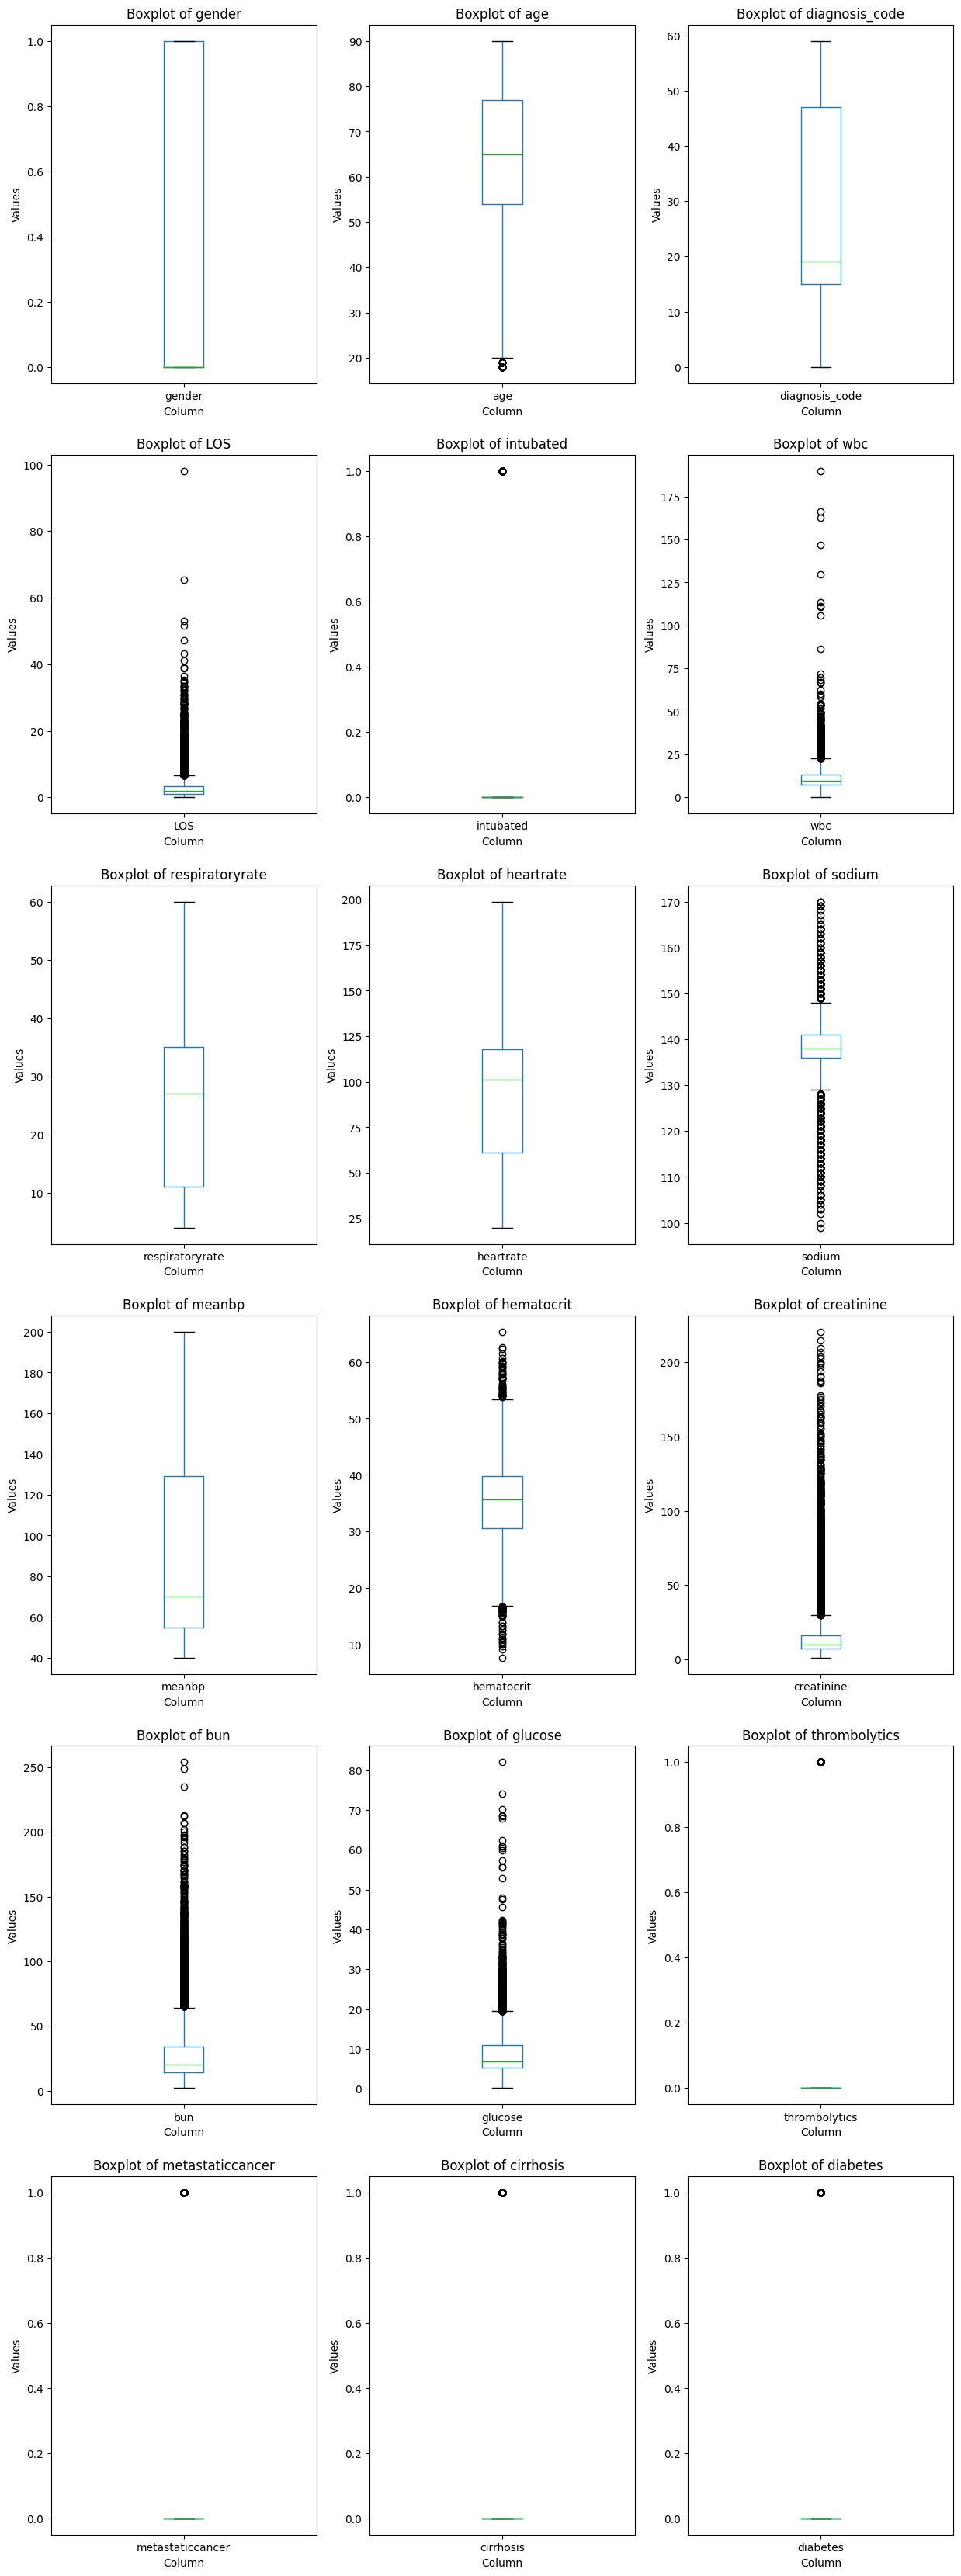

In [ ]:
# Select numeric columns only
numeric_columns = df_cardiac_ed.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_cardiac_ed.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

In [ ]:
df_cardiac_ed_no_outliers.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000,3291.000000
mean,0.431176,61.852628,31.577028,1.429641,0.039502,8.807770,22.726831,86.604983,138.985111,93.309328,38.085491,7.525128,14.392191,5.640626,0.085384,0.005469,0.004558,0.059860
std,0.495316,16.305793,17.102313,0.664417,0.194815,2.779006,14.708943,31.814998,2.762002,37.568398,4.645549,1.852614,4.887118,0.863001,0.279495,0.073764,0.067368,0.237264
min,0.000000,20.000000,0.000000,0.038194,0.000000,1.310000,4.000000,24.000000,132.000000,40.000000,26.200000,2.475248,2.000000,3.600000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,51.000000,16.000000,0.929861,0.000000,6.800000,10.000000,55.000000,137.000000,60.000000,35.050000,6.188119,11.000000,5.100000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,62.000000,34.000000,1.268750,0.000000,8.500000,16.000000,94.000000,139.000000,76.000000,38.300000,7.337341,14.000000,5.600000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,74.000000,47.000000,1.854861,0.000000,10.500000,33.000000,110.000000,141.000000,125.000000,41.300000,8.840170,18.000000,6.200000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,3.198611,1.000000,16.000000,60.000000,190.000000,145.000000,200.000000,50.000000,11.934229,27.000000,7.700000,1.000000,1.000000,1.000000,1.000000


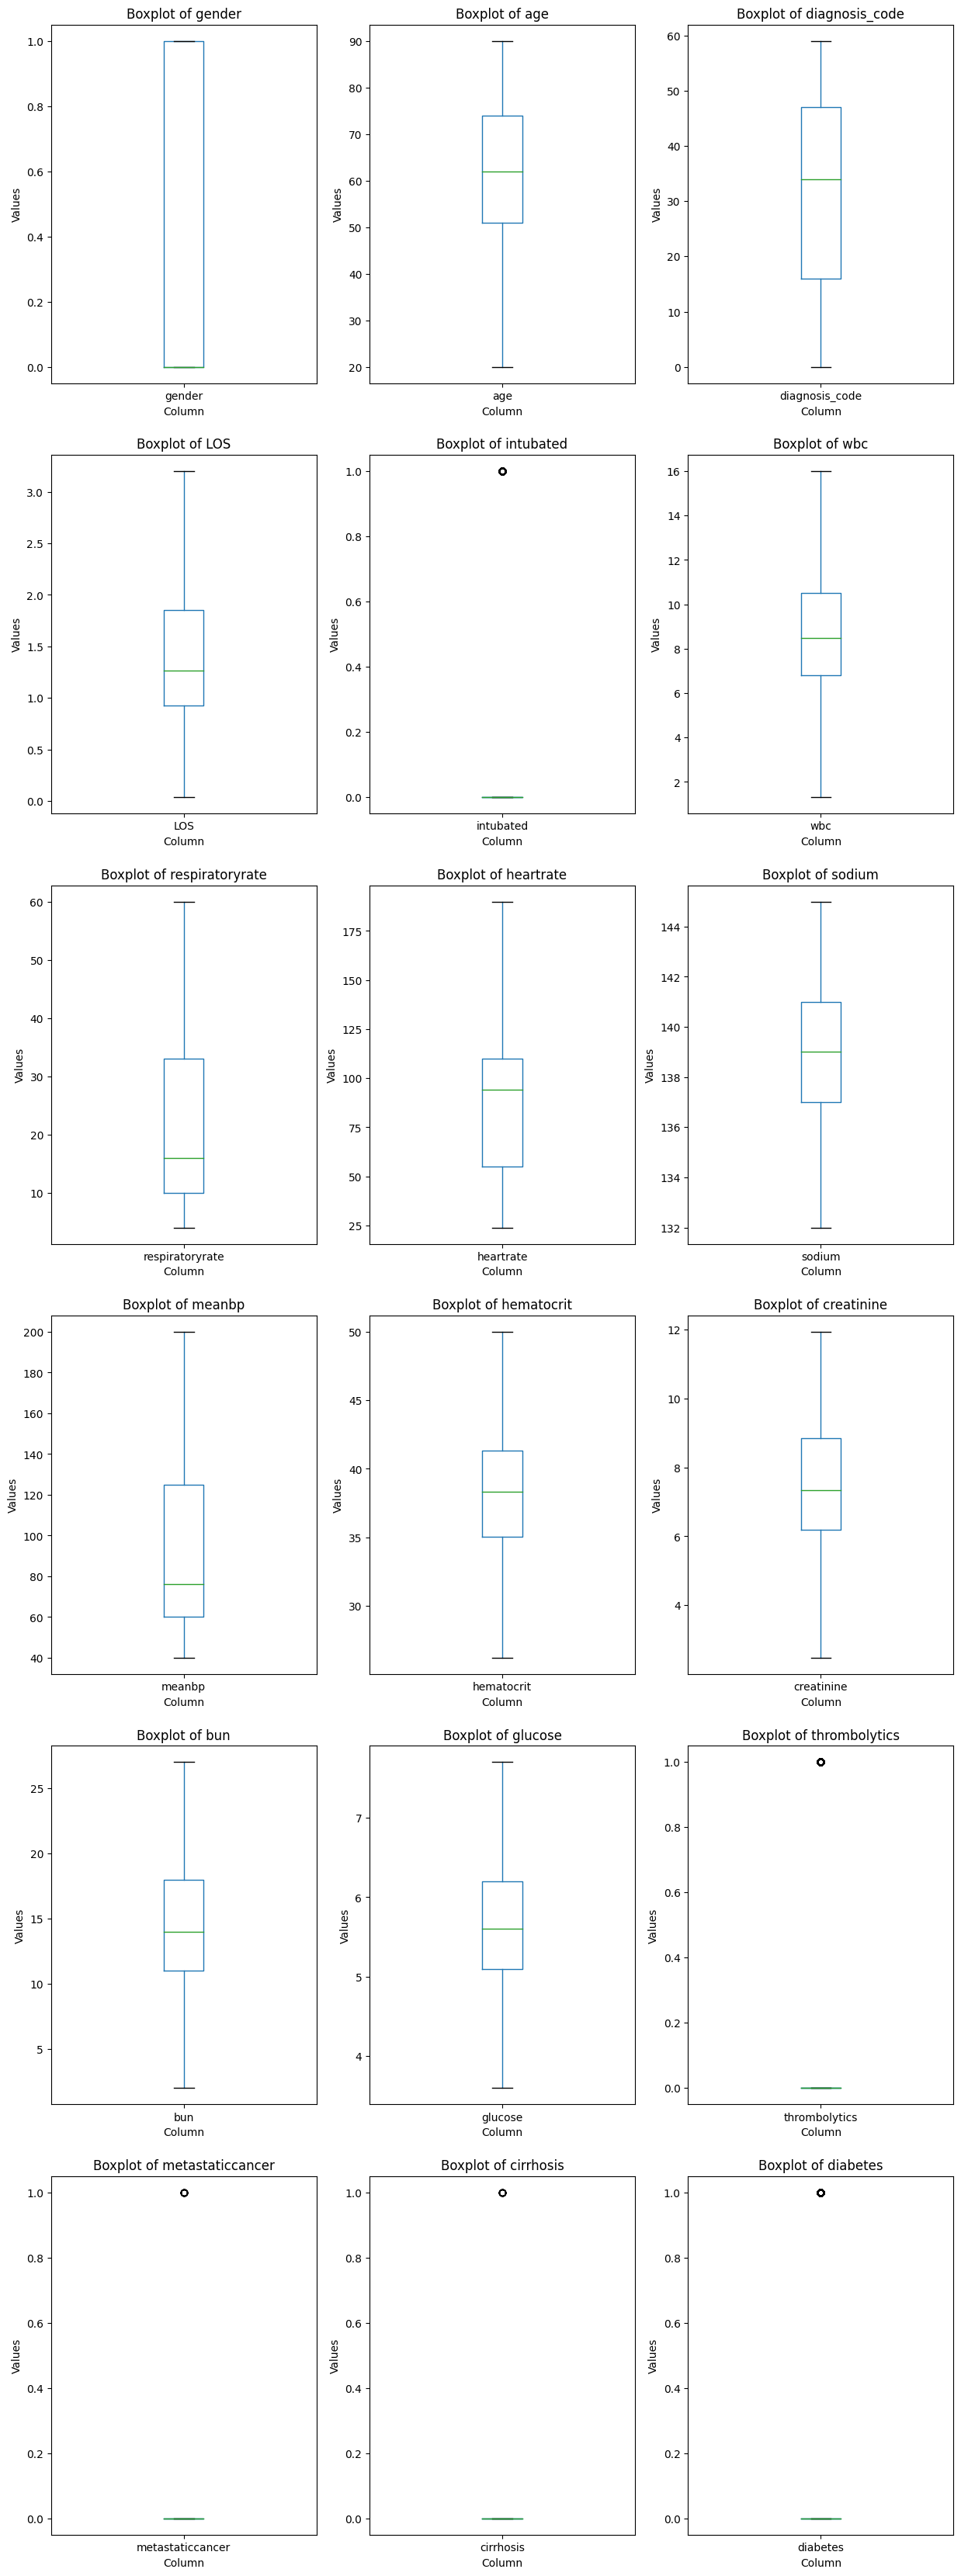

In [ ]:
# Select numeric columns only
numeric_columns = df_cardiac_ed_no_outliers.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_cardiac_ed_no_outliers.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

In [ ]:
df_cardiac_ed_quantile.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,0.438084,65.577567,29.021448,2.458403,0.155713,10.407344,25.049678,95.665459,137.972574,92.012269,35.157449,12.129255,25.719738,8.385617,0.057242,0.011159,0.012318,0.238678
std,0.496170,13.960574,17.787314,1.766863,0.362597,4.313488,14.869226,32.426198,3.421915,42.849547,5.580079,6.806086,15.813584,3.909520,0.232313,0.105047,0.110305,0.426291
min,0.000000,44.000000,0.000000,0.038194,0.000000,0.070000,4.000000,20.000000,132.000000,40.000000,26.000000,0.972419,2.000000,0.200000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,15.000000,1.087500,0.000000,7.180000,11.000000,61.000000,136.000000,55.000000,30.600000,6.983734,14.000000,5.300000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,19.000000,1.850694,0.000000,9.500000,27.000000,101.000000,138.000000,70.000000,35.600000,9.724187,20.000000,6.900000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.000000,47.000000,3.260417,0.000000,13.340000,35.000000,118.000000,141.000000,129.000000,39.800000,16.089109,34.000000,11.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,6.222917,1.000000,18.400000,60.000000,199.000000,143.000000,200.000000,43.300000,24.752475,58.000000,15.900000,1.000000,1.000000,1.000000,1.000000


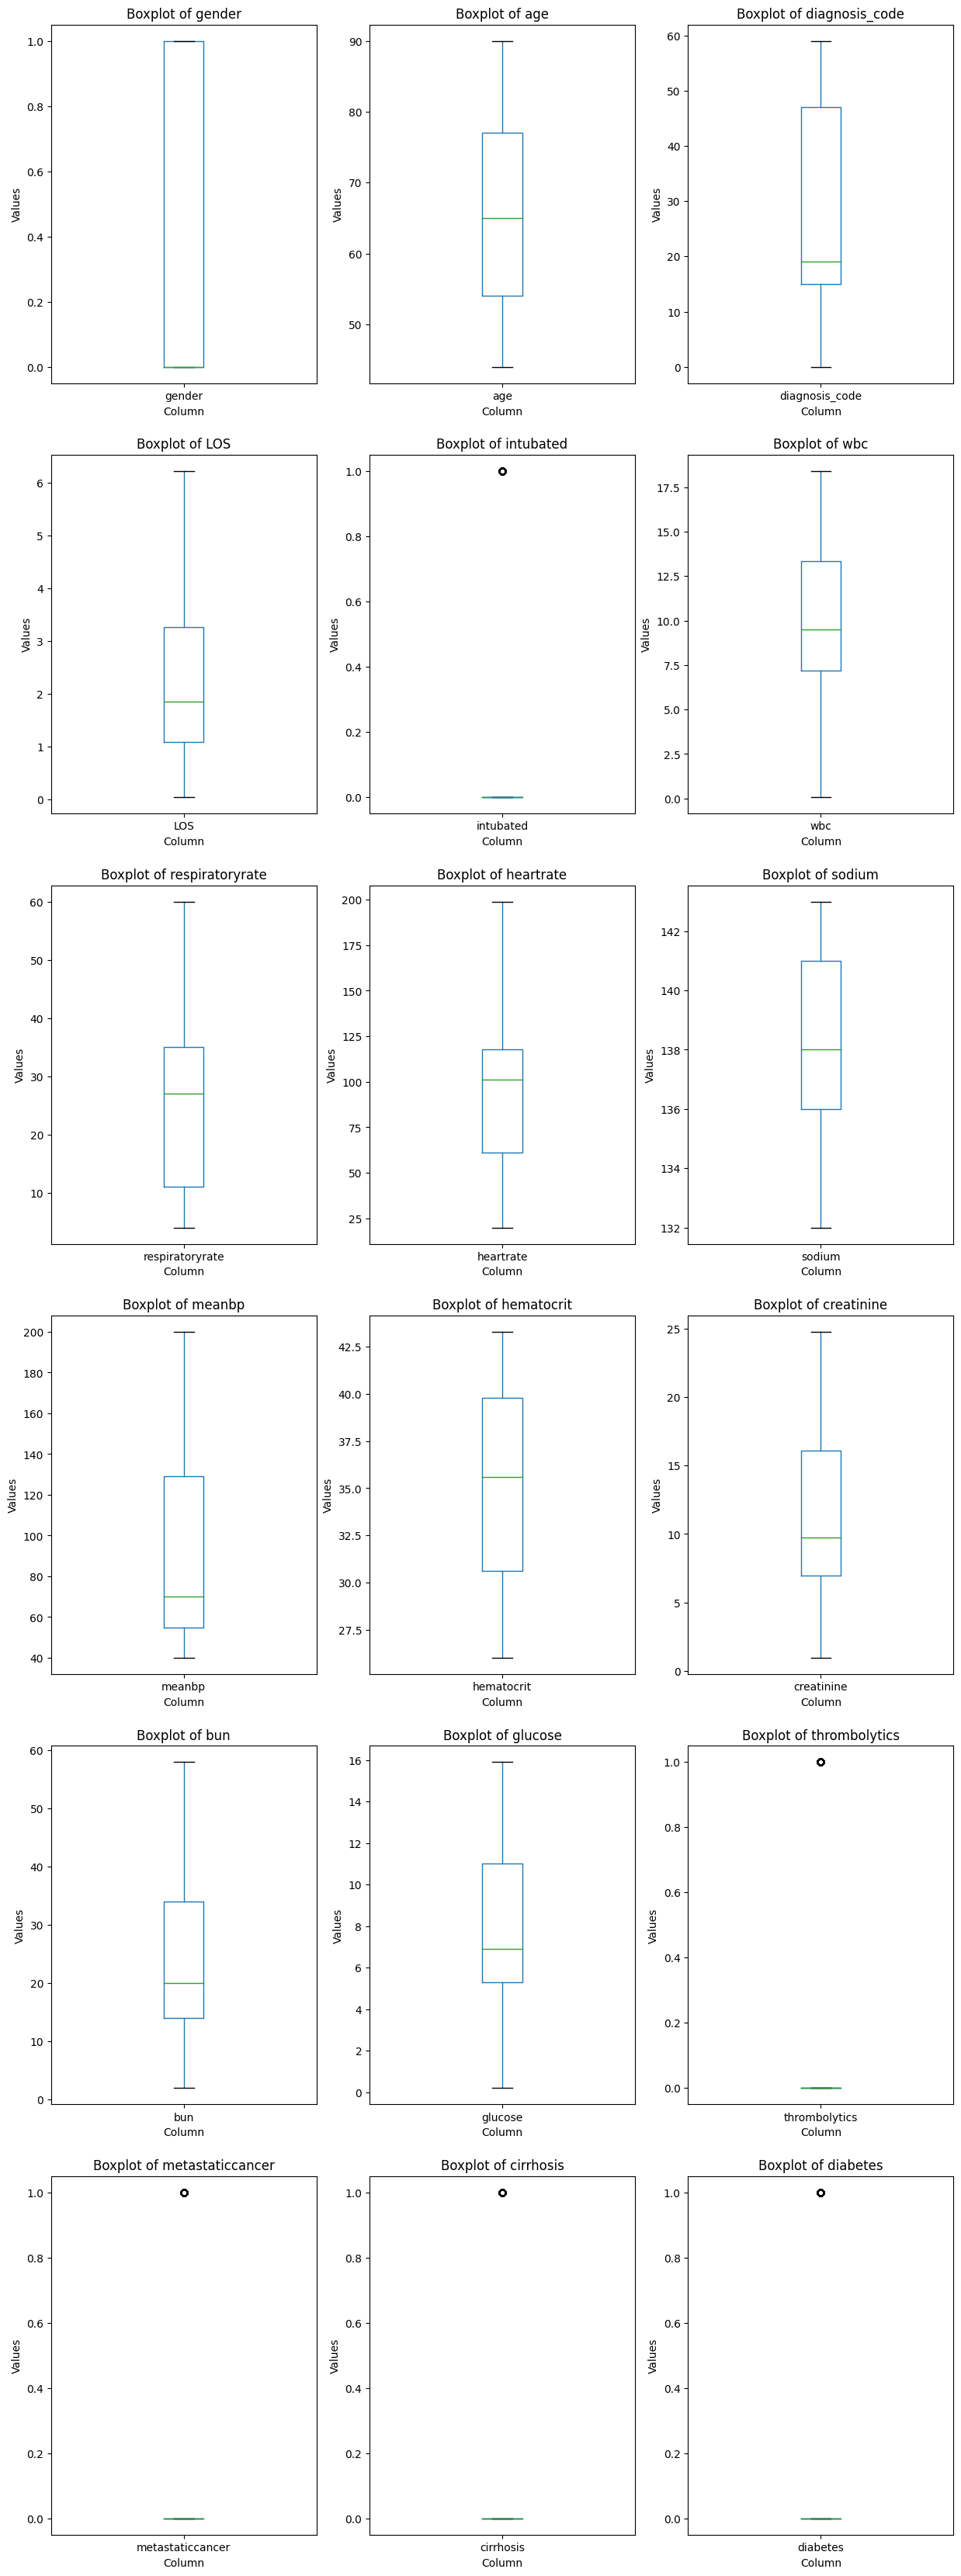

In [ ]:
# Select numeric columns only
numeric_columns = df_cardiac_ed_quantile.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_cardiac_ed_quantile.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

## Adjust the skewness of the LOS column

In [ ]:
from scipy.stats import skew

# See the skewness of the LOS column
target_skewness = skew(df_cardiac_ed['LOS'])
print("Skewness:", target_skewness)

Skewness: 5.281137022886127


In [ ]:
from scipy.stats import skew

# See the skewness of the LOS column
target_skewness = skew(df_cardiac_ed_no_outliers['LOS'])
print("Skewness:", target_skewness)

Skewness: 0.7041526255746846


In [ ]:
from scipy.stats import skew

# See the skewness of the LOS column
target_skewness = skew(df_cardiac_ed_quantile['LOS'])
print("Skewness:", target_skewness)

Skewness: 1.0261392789602133


inference:
- It's positively skewed

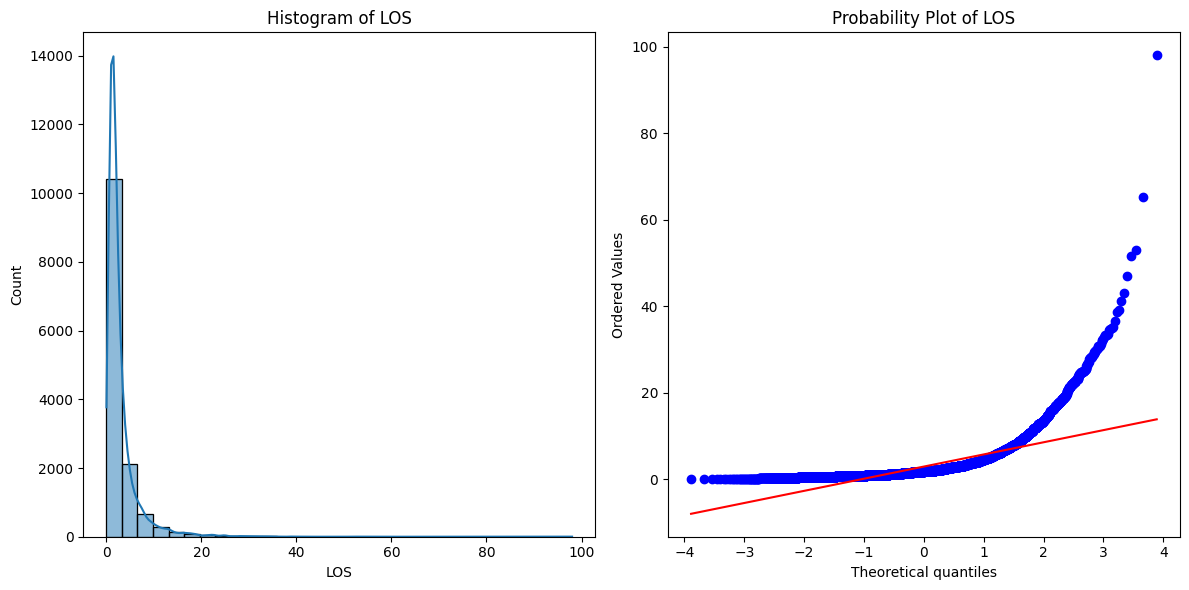

In [ ]:
from scipy.stats import probplot

plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_cardiac_ed['LOS'], bins=30, kde=True)
plt.title('Histogram of LOS')

# Probability plot
plt.subplot(1, 2, 2)
probplot(df_cardiac_ed['LOS'], plot=plt)
plt.title('Probability Plot of LOS')

plt.tight_layout()
plt.show()

In [ ]:
# make a copy of the 3 different dataset with a skew LOS column
df_cardiac_ed_skew = df_cardiac_ed.copy()
df_cardiac_ed_no_outliers_skew = df_cardiac_ed_no_outliers.copy()
df_cardiac_ed_quantile_skew = df_cardiac_ed_quantile.copy()
df_ppum_skew = df_ppum.copy()

In [ ]:
# Create 'LOS_log' column with log-transformed LOS data
df_cardiac_ed_skew['LOS_log'] = np.log1p(df_cardiac_ed_skew['LOS'])
df_cardiac_ed_no_outliers_skew['LOS_log'] = np.log1p(df_cardiac_ed_no_outliers_skew['LOS'])
df_cardiac_ed_quantile_skew['LOS_log'] = np.log1p(df_cardiac_ed_quantile_skew['LOS'])
df_ppum_skew['LOS_log'] = np.log1p(df_ppum_skew['LOS'])

In [ ]:
# Remove 'LOS' column
df_cardiac_ed_skew = df_cardiac_ed_skew.drop(['LOS'], axis=1)
df_cardiac_ed_no_outliers_skew = df_cardiac_ed_no_outliers_skew.drop(['LOS'], axis=1)
df_cardiac_ed_quantile_skew = df_cardiac_ed_quantile_skew.drop(['LOS'], axis=1)
df_ppum_skew = df_ppum_skew.drop(['LOS'], axis=1)

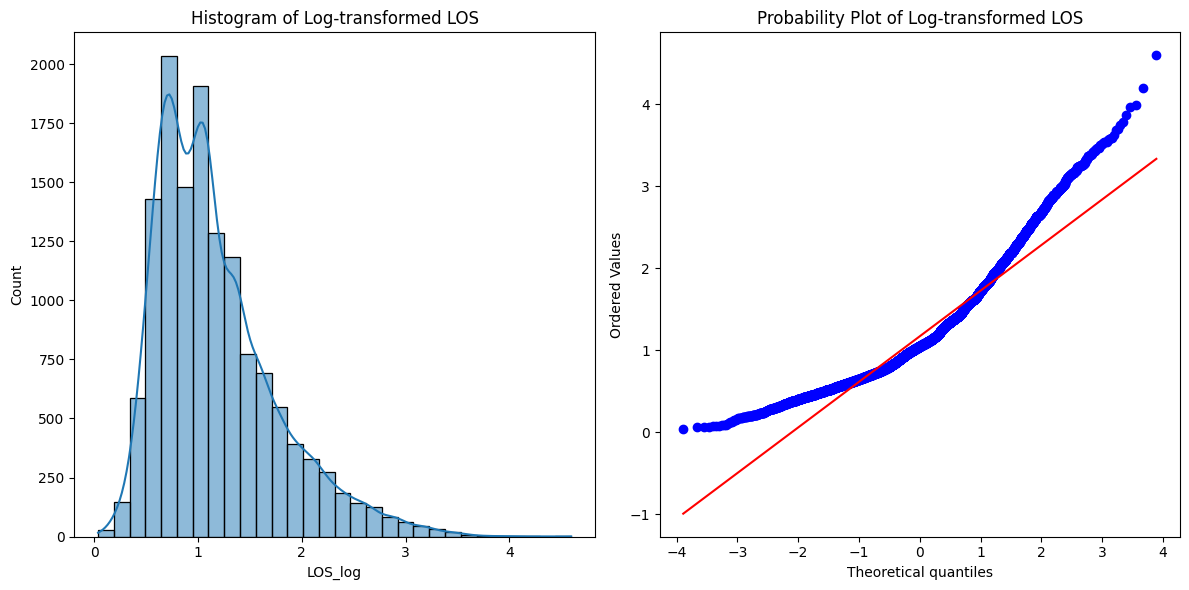

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram of log-transformed LOS
plt.subplot(1, 2, 1)
sns.histplot(df_cardiac_ed_skew['LOS_log'], bins=30, kde=True)
plt.title('Histogram of Log-transformed LOS')

# Probability plot of log-transformed LOS
plt.subplot(1, 2, 2)
probplot(df_cardiac_ed_skew['LOS_log'], plot=plt)
plt.title('Probability Plot of Log-transformed LOS')

plt.tight_layout()
plt.show()

In [ ]:
df_cardiac_ed_skew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13801 entries, 0 to 13800
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            13801 non-null  int64  
 1   age               13801 non-null  float64
 2   diagnosis_code    13801 non-null  int64  
 3   intubated         13801 non-null  float64
 4   wbc               13801 non-null  float64
 5   respiratoryrate   13801 non-null  float64
 6   heartrate         13801 non-null  float64
 7   sodium            13801 non-null  float64
 8   meanbp            13801 non-null  float64
 9   hematocrit        13801 non-null  float64
 10  creatinine        13801 non-null  float64
 11  bun               13801 non-null  float64
 12  glucose           13801 non-null  float64
 13  thrombolytics     13801 non-null  float64
 14  metastaticcancer  13801 non-null  float64
 15  cirrhosis         13801 non-null  float64
 16  diabetes          13801 non-null  float6

## **Deep Learning** with Normal dataset

In [ ]:
# Splitting the data into features and target variable
X = df_cardiac_ed_skew.drop(["LOS_log"], axis=1)
y = df_cardiac_ed_skew["LOS_log"]
numeric_columns = X.select_dtypes(include=np.number).columns.tolist()  # Numeric columns for scaling
columns = X.columns.tolist()

# PPUM (Test) Data
X_ppum = df_ppum_skew.drop(["LOS_log"], axis=1)
y_ppum = df_ppum_skew["LOS_log"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features data
scaler = MinMaxScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
# X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])
X_ppum[numeric_columns] = scaler.transform(X_ppum[numeric_columns])

# Reshape the data accordingly
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
X_ppum_reshaped = X_ppum.values.reshape(X_ppum.shape[0], X_ppum.shape[1], 1)

# Reshape the data in 2d array for DBN
X_train_reshaped_dbn = X_train.values.reshape(X_train.shape[0], X_train.shape[1])
# X_test_reshaped_dbn = X_test.values.reshape(X_test.shape[0], X_test.shape[1])
X_ppum_reshaped_dbn = X_ppum.values.reshape(X_ppum.shape[0], X_ppum.shape[1])

# Define the RNN model
model_rnn = Sequential([
    SimpleRNN(10, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])
model_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training RNN model")
model_rnn.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Define the LSTM model
model_lstm = Sequential([
    LSTM(10, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training LSTM model")
model_lstm.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Define the GRU model
model_gru = Sequential([
    GRU(10, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])
model_gru.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training GRU model")
model_gru.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Define the TCN model
input_layer = Input(shape=(X_train_reshaped.shape[1], 1))
conv1 = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(input_layer)
conv2 = Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu')(conv1)
output_layer_tcn = Dense(1)(conv2)
model_tcn = Model(inputs=input_layer, outputs=output_layer_tcn)
model_tcn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training TCN model")
model_tcn.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Function to create an RBM
def create_rbm(input_size, output_size):
    rbm_model = tf.keras.models.Sequential()
    rbm_model.add(tf.keras.layers.Dense(output_size, activation='sigmoid', input_shape=(input_size,)))
    rbm_model.add(tf.keras.layers.Dense(input_size, activation='sigmoid'))
    rbm_model.compile(optimizer='adam', loss='mean_squared_error')
    return rbm_model

def pretrain_dbn_layers(X_train, layers):
    rbms = []
    input_size = X_train_reshaped_dbn.shape[1]
    train_data = X_train_reshaped_dbn.copy()  # Create a copy to maintain original data
    for i in range(layers):
        rbm = create_rbm(input_size, 17)  # the number of neurons
        rbm.fit(train_data, train_data, epochs=10, batch_size=32)  # Pretraining each layer
        rbms.append(rbm)
        train_data = rbm.predict(train_data)  # Use the hidden layer activations for the next RBM
    return rbms

# Create and train the RBMs
rbms = pretrain_dbn_layers(X_train_reshaped_dbn, 3)  # Creating a DBN with 3 RBM layers

# Construct the DBN model
dbn_model = tf.keras.models.Sequential()
for rbm in rbms:
    dbn_model.add(rbm.layers[0])  # Add the hidden layer of each RBM

# Add an output layer for regression
dbn_model.add(tf.keras.layers.Dense(1))

# Compile the DBN model
dbn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training DBN model")
dbn_model.fit(X_train_reshaped_dbn, y_train, epochs=100, batch_size=32)

# Evaluation for all models
loss_rnn, mae_rnn, mse_rnn = model_rnn.evaluate(X_ppum_reshaped, y_ppum)
rmse_rnn = np.sqrt(mse_rnn)

loss_lstm, mae_lstm, mse_lstm = model_lstm.evaluate(X_ppum_reshaped, y_ppum)
rmse_lstm = np.sqrt(mse_lstm)

loss_gru, mae_gru, mse_gru = model_gru.evaluate(X_ppum_reshaped, y_ppum)
rmse_gru = np.sqrt(mse_gru)

loss_tcn, mae_tcn, mse_tcn = model_tcn.evaluate(X_ppum_reshaped, y_ppum)
rmse_tcn = np.sqrt(mse_tcn)

loss_dbn, mae_dbn, mse_dbn = dbn_model.evaluate(X_ppum_reshaped_dbn, y_ppum)
rmse_dbn = np.sqrt(mse_dbn)

print("\nRNN Test Loss:", loss_rnn)
print("RNN MSE:", mse_rnn)
print("RNN RMSE:", rmse_rnn)
print("RNN MAE:", mae_rnn)

print("\nLSTM Test Loss:", loss_lstm)
print("LSTM MSE:", mse_lstm)
print("LSTM RMSE:", rmse_lstm)
print("LSTM MAE:", mae_lstm)

print("\nGRU Test Loss:", loss_gru)
print("GRU MSE:", mse_gru)
print("GRU RMSE:", rmse_gru)
print("GRU MAE:", mae_gru)

print("\nTCN Test Loss:", loss_tcn)
print("TCN MSE:", mse_tcn)
print("TCN RMSE:", rmse_tcn)
print("TCN MAE:", mae_tcn)

print("\nDBN Test Loss:", loss_dbn)
print("DBN MSE:", mse_dbn)
print("DBN RMSE:", rmse_dbn)
print("DBN MAE:", mae_dbn)

Training RNN model
Epoch 1/100
345/345 [==============================] - 5s 7ms/step - loss: 0.6724 - mae: 0.6111 - mse: 0.6724
Epoch 2/100
345/345 [==============================] - 3s 7ms/step - loss: 0.3544 - mae: 0.4554 - mse: 0.3544
Epoch 3/100
345/345 [==============================] - 3s 7ms/step - loss: 0.3431 - mae: 0.4505 - mse: 0.3431
Epoch 4/100
345/345 [==============================] - 3s 8ms/step - loss: 0.3385 - mae: 0.4478 - mse: 0.3385
Epoch 5/100
345/345 [==============================] - 3s 7ms/step - loss: 0.3349 - mae: 0.4462 - mse: 0.3349
Epoch 6/100
345/345 [==============================] - 3s 7ms/step - loss: 0.3292 - mae: 0.4422 - mse: 0.3292
Epoch 7/100
345/345 [==============================] - 2s 7ms/step - loss: 0.3270 - mae: 0.4401 - mse: 0.3270
Epoch 8/100
345/345 [==============================] - 3s 7ms/step - loss: 0.3232 - mae: 0.4375 - mse: 0.3232
Epoch 9/100
345/345 [==============================] - 3s 8ms/step - loss: 0.3204 - mae: 0.4352 - mse

1/1 [==============================] - 0s 122ms/step - loss: 0.5448 - mae: 0.5893 - mse: 0.5448

RNN Test Loss: 0.45482736825942993
RNN MSE: 0.45482736825942993
RNN RMSE: 0.6744089028619283
RNN MAE: 0.5344655513763428

LSTM Test Loss: 0.48081693053245544
LSTM MSE: 0.48081693053245544
LSTM RMSE: 0.6934096412168318
LSTM MAE: 0.5493924021720886

GRU Test Loss: 0.4740488529205322
GRU MSE: 0.4740488529205322
GRU RMSE: 0.6885120572078112
GRU MAE: 0.5445501208305359

TCN Test Loss: 0.4770110547542572
TCN MSE: 0.4770110547542572
TCN RMSE: 0.690659869077578
TCN MAE: 0.5457528829574585

DBN Test Loss: 0.54482102394104
DBN MSE: 0.54482102394104
DBN RMSE: 0.7381199251754691
DBN MAE: 0.5892894864082336


## **Deep Learning** with dataset contains **no outliers**

In [ ]:
# Splitting the data into features and target variable
X = df_cardiac_ed_no_outliers_skew.drop(["LOS_log"], axis=1)
y = df_cardiac_ed_no_outliers_skew["LOS_log"]
numeric_columns = X.select_dtypes(include=np.number).columns.tolist()  # Numeric columns for scaling
columns = X.columns.tolist()

# PPUM (Test) Data
X_ppum = df_ppum_skew.drop(["LOS_log"], axis=1)
y_ppum = df_ppum_skew["LOS_log"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features data
scaler = MinMaxScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
# X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])
X_ppum[numeric_columns] = scaler.transform(X_ppum[numeric_columns])

# Reshape the data accordingly
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
X_ppum_reshaped = X_ppum.values.reshape(X_ppum.shape[0], X_ppum.shape[1], 1)

# Reshape the data in 2d array for DBN
X_train_reshaped_dbn = X_train.values.reshape(X_train.shape[0], X_train.shape[1])
# X_test_reshaped_dbn = X_test.values.reshape(X_test.shape[0], X_test.shape[1])
X_ppum_reshaped_dbn = X_ppum.values.reshape(X_ppum.shape[0], X_ppum.shape[1])

# Define the RNN model
model_rnn = Sequential([
    SimpleRNN(10, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])
model_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training RNN model")
model_rnn.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Define the LSTM model
model_lstm = Sequential([
    LSTM(10, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training LSTM model")
model_lstm.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Define the GRU model
model_gru = Sequential([
    GRU(10, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])
model_gru.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training GRU model")
model_gru.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Define the TCN model
input_layer = Input(shape=(X_train_reshaped.shape[1], 1))
conv1 = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(input_layer)
conv2 = Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu')(conv1)
output_layer_tcn = Dense(1)(conv2)
model_tcn = Model(inputs=input_layer, outputs=output_layer_tcn)
model_tcn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training TCN model")
model_tcn.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Function to create an RBM
def create_rbm(input_size, output_size):
    rbm_model = tf.keras.models.Sequential()
    rbm_model.add(tf.keras.layers.Dense(output_size, activation='sigmoid', input_shape=(input_size,)))
    rbm_model.add(tf.keras.layers.Dense(input_size, activation='sigmoid'))
    rbm_model.compile(optimizer='adam', loss='mean_squared_error')
    return rbm_model

def pretrain_dbn_layers(X_train, layers):
    rbms = []
    input_size = X_train_reshaped_dbn.shape[1]
    train_data = X_train_reshaped_dbn.copy()  # Create a copy to maintain original data
    for i in range(layers):
        rbm = create_rbm(input_size, 17)  # the number of neurons
        rbm.fit(train_data, train_data, epochs=10, batch_size=32)  # Pretraining each layer
        rbms.append(rbm)
        train_data = rbm.predict(train_data)  # Use the hidden layer activations for the next RBM
    return rbms

# Create and train the RBMs
rbms = pretrain_dbn_layers(X_train_reshaped_dbn, 3)  # Creating a DBN with 3 RBM layers

# Construct the DBN model
dbn_model = tf.keras.models.Sequential()
for rbm in rbms:
    dbn_model.add(rbm.layers[0])  # Add the hidden layer of each RBM

# Add an output layer for regression
dbn_model.add(tf.keras.layers.Dense(1))

# Compile the DBN model
dbn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training DBN model")
dbn_model.fit(X_train_reshaped_dbn, y_train, epochs=100, batch_size=32)

# Evaluation for all models
loss_rnn, mae_rnn, mse_rnn = model_rnn.evaluate(X_ppum_reshaped, y_ppum)
rmse_rnn = np.sqrt(mse_rnn)

loss_lstm, mae_lstm, mse_lstm = model_lstm.evaluate(X_ppum_reshaped, y_ppum)
rmse_lstm = np.sqrt(mse_lstm)

loss_gru, mae_gru, mse_gru = model_gru.evaluate(X_ppum_reshaped, y_ppum)
rmse_gru = np.sqrt(mse_gru)

loss_tcn, mae_tcn, mse_tcn = model_tcn.evaluate(X_ppum_reshaped, y_ppum)
rmse_tcn = np.sqrt(mse_tcn)

loss_dbn, mae_dbn, mse_dbn = dbn_model.evaluate(X_ppum_reshaped_dbn, y_ppum)
rmse_dbn = np.sqrt(mse_dbn)

print("\nRNN Test Loss:", loss_rnn)
print("RNN MSE:", mse_rnn)
print("RNN RMSE:", rmse_rnn)
print("RNN MAE:", mae_rnn)

print("\nLSTM Test Loss:", loss_lstm)
print("LSTM MSE:", mse_lstm)
print("LSTM RMSE:", rmse_lstm)
print("LSTM MAE:", mae_lstm)

print("\nGRU Test Loss:", loss_gru)
print("GRU MSE:", mse_gru)
print("GRU RMSE:", rmse_gru)
print("GRU MAE:", mae_gru)

print("\nTCN Test Loss:", loss_tcn)
print("TCN MSE:", mse_tcn)
print("TCN RMSE:", rmse_tcn)
print("TCN MAE:", mae_tcn)

print("\nDBN Test Loss:", loss_dbn)
print("DBN MSE:", mse_dbn)
print("DBN RMSE:", rmse_dbn)
print("DBN MAE:", mae_dbn)

Training RNN model
Epoch 1/100
83/83 [==============================] - 2s 10ms/step - loss: 0.2390 - mae: 0.3889 - mse: 0.2390
Epoch 2/100
83/83 [==============================] - 1s 10ms/step - loss: 0.1142 - mae: 0.2702 - mse: 0.1142
Epoch 3/100
83/83 [==============================] - 1s 10ms/step - loss: 0.0989 - mae: 0.2530 - mse: 0.0989
Epoch 4/100
83/83 [==============================] - 1s 10ms/step - loss: 0.0914 - mae: 0.2452 - mse: 0.0914
Epoch 5/100
83/83 [==============================] - 1s 10ms/step - loss: 0.0864 - mae: 0.2393 - mse: 0.0864
Epoch 6/100
83/83 [==============================] - 1s 10ms/step - loss: 0.0829 - mae: 0.2356 - mse: 0.0829
Epoch 7/100
83/83 [==============================] - 1s 10ms/step - loss: 0.0804 - mae: 0.2332 - mse: 0.0804
Epoch 8/100
83/83 [==============================] - 1s 10ms/step - loss: 0.0786 - mae: 0.2312 - mse: 0.0786
Epoch 9/100
83/83 [==============================] - 1s 10ms/step - loss: 0.0777 - mae: 0.2303 - mse: 0.0777


1/1 [==============================] - 0s 121ms/step - loss: 0.4955 - mae: 0.5663 - mse: 0.4955

RNN Test Loss: 0.523745059967041
RNN MSE: 0.523745059967041
RNN RMSE: 0.7237023282863204
RNN MAE: 0.5878373384475708

LSTM Test Loss: 0.4810100495815277
LSTM MSE: 0.4810100495815277
LSTM RMSE: 0.6935488804558246
LSTM MAE: 0.5567819476127625

GRU Test Loss: 0.49140816926956177
GRU MSE: 0.49140816926956177
GRU RMSE: 0.7010051135830335
GRU MAE: 0.5627914667129517

TCN Test Loss: 0.5669122934341431
TCN MSE: 0.5669122934341431
TCN RMSE: 0.752935783074588
TCN MAE: 0.6057947278022766

DBN Test Loss: 0.4955434799194336
DBN MSE: 0.4955434799194336
DBN RMSE: 0.7039484923767033
DBN MAE: 0.5662712454795837


## **Deep Learning** with Dataset using **Quantile based flooring and capping**

In [ ]:
# Splitting the data into features and target variable
X = df_cardiac_ed_quantile_skew.drop(["LOS_log"], axis=1)
y = df_cardiac_ed_quantile_skew["LOS_log"]
numeric_columns = X.select_dtypes(include=np.number).columns.tolist()  # Numeric columns for scaling
columns = X.columns.tolist()

# PPUM (Test) Data
X_ppum = df_ppum_skew.drop(["LOS_log"], axis=1)
y_ppum = df_ppum_skew["LOS_log"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features data
scaler = MinMaxScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
# X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])
X_ppum[numeric_columns] = scaler.transform(X_ppum[numeric_columns])

# Reshape the data accordingly
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
X_ppum_reshaped = X_ppum.values.reshape(X_ppum.shape[0], X_ppum.shape[1], 1)

# Reshape the data in 2d array for DBN
X_train_reshaped_dbn = X_train.values.reshape(X_train.shape[0], X_train.shape[1])
# X_test_reshaped_dbn = X_test.values.reshape(X_test.shape[0], X_test.shape[1])
X_ppum_reshaped_dbn = X_ppum.values.reshape(X_ppum.shape[0], X_ppum.shape[1])

# Define the RNN model
model_rnn = Sequential([
    SimpleRNN(10, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])
model_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training RNN model")
model_rnn.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Define the LSTM model
model_lstm = Sequential([
    LSTM(10, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training LSTM model")
model_lstm.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Define the GRU model
model_gru = Sequential([
    GRU(10, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])
model_gru.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training GRU model")
model_gru.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Define the TCN model
input_layer = Input(shape=(X_train_reshaped.shape[1], 1))
conv1 = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(input_layer)
conv2 = Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu')(conv1)
output_layer_tcn = Dense(1)(conv2)
model_tcn = Model(inputs=input_layer, outputs=output_layer_tcn)
model_tcn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training TCN model")
model_tcn.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Function to create an RBM
def create_rbm(input_size, output_size):
    rbm_model = tf.keras.models.Sequential()
    rbm_model.add(tf.keras.layers.Dense(output_size, activation='sigmoid', input_shape=(input_size,)))
    rbm_model.add(tf.keras.layers.Dense(input_size, activation='sigmoid'))
    rbm_model.compile(optimizer='adam', loss='mean_squared_error')
    return rbm_model

def pretrain_dbn_layers(X_train, layers):
    rbms = []
    input_size = X_train_reshaped_dbn.shape[1]
    train_data = X_train_reshaped_dbn.copy()  # Create a copy to maintain original data
    for i in range(layers):
        rbm = create_rbm(input_size, 17)  # the number of neurons
        rbm.fit(train_data, train_data, epochs=10, batch_size=32)  # Pretraining each layer
        rbms.append(rbm)
        train_data = rbm.predict(train_data)  # Use the hidden layer activations for the next RBM
    return rbms

# Create and train the RBMs
rbms = pretrain_dbn_layers(X_train_reshaped_dbn, 3)  # Creating a DBN with 3 RBM layers

# Construct the DBN model
dbn_model = tf.keras.models.Sequential()
for rbm in rbms:
    dbn_model.add(rbm.layers[0])  # Add the hidden layer of each RBM

# Add an output layer for regression
dbn_model.add(tf.keras.layers.Dense(1))

# Compile the DBN model
dbn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training DBN model")
dbn_model.fit(X_train_reshaped_dbn, y_train, epochs=100, batch_size=32)

# Evaluation for all models
loss_rnn, mae_rnn, mse_rnn = model_rnn.evaluate(X_ppum_reshaped, y_ppum)
rmse_rnn = np.sqrt(mse_rnn)

loss_lstm, mae_lstm, mse_lstm = model_lstm.evaluate(X_ppum_reshaped, y_ppum)
rmse_lstm = np.sqrt(mse_lstm)

loss_gru, mae_gru, mse_gru = model_gru.evaluate(X_ppum_reshaped, y_ppum)
rmse_gru = np.sqrt(mse_gru)

loss_tcn, mae_tcn, mse_tcn = model_tcn.evaluate(X_ppum_reshaped, y_ppum)
rmse_tcn = np.sqrt(mse_tcn)

loss_dbn, mae_dbn, mse_dbn = dbn_model.evaluate(X_ppum_reshaped_dbn, y_ppum)
rmse_dbn = np.sqrt(mse_dbn)

print("\nRNN Test Loss:", loss_rnn)
print("RNN MSE:", mse_rnn)
print("RNN RMSE:", rmse_rnn)
print("RNN MAE:", mae_rnn)

print("\nLSTM Test Loss:", loss_lstm)
print("LSTM MSE:", mse_lstm)
print("LSTM RMSE:", rmse_lstm)
print("LSTM MAE:", mae_lstm)

print("\nGRU Test Loss:", loss_gru)
print("GRU MSE:", mse_gru)
print("GRU RMSE:", rmse_gru)
print("GRU MAE:", mae_gru)

print("\nTCN Test Loss:", loss_tcn)
print("TCN MSE:", mse_tcn)
print("TCN RMSE:", rmse_tcn)
print("TCN MAE:", mae_tcn)

print("\nDBN Test Loss:", loss_dbn)
print("DBN MSE:", mse_dbn)
print("DBN RMSE:", rmse_dbn)
print("DBN MAE:", mae_dbn)

Training RNN model
Epoch 1/100
345/345 [==============================] - 4s 7ms/step - loss: 0.3768 - mae: 0.4868 - mse: 0.3768
Epoch 2/100
345/345 [==============================] - 3s 7ms/step - loss: 0.2510 - mae: 0.4116 - mse: 0.2510
Epoch 3/100
345/345 [==============================] - 2s 7ms/step - loss: 0.2343 - mae: 0.4003 - mse: 0.2343
Epoch 4/100
345/345 [==============================] - 3s 7ms/step - loss: 0.2282 - mae: 0.3966 - mse: 0.2282
Epoch 5/100
345/345 [==============================] - 3s 8ms/step - loss: 0.2256 - mae: 0.3952 - mse: 0.2256
Epoch 6/100
345/345 [==============================] - 2s 7ms/step - loss: 0.2244 - mae: 0.3944 - mse: 0.2244
Epoch 7/100
345/345 [==============================] - 3s 7ms/step - loss: 0.2242 - mae: 0.3946 - mse: 0.2242
Epoch 8/100
345/345 [==============================] - 3s 7ms/step - loss: 0.2237 - mae: 0.3942 - mse: 0.2237
Epoch 9/100
345/345 [==============================] - 3s 8ms/step - loss: 0.2235 - mae: 0.3940 - mse

## Results

In [ ]:
results = {
    'Dataset': ['normal dataset'] * 5 + ['no outliers'] * 5 + ['Quantile based flooring and capping'] * 5,
    'Model': ['RNN', 'LSTM', 'GRU', 'TCN', 'DBN'] * 3,
    'MSE': [0.45482736825942993, 0.48081693053245544, 0.4740488529205322, 0.4770110547542572, 0.54482102394104,
            0.523745059967041, 0.4810100495815277, 0.49140816926956177, 0.5669122934341431, 0.4955434799194336,
            0.4604167342185974, 0.45102524757385254, 0.472032368183136, 1.7316982746124268, 0.4908302426338196],
    'RMSE': [0.6744089028619283, 0.6934096412168318, 0.6885120572078112, 0.690659869077578, 0.7381199251754691,
             0.7237023282863204, 0.6935488804558246, 0.7010051135830335, 0.752935783074588, 0.7039484923767033,
             0.6785401493048127, 0.6715841329080464, 0.6870461179448843, 1.3159400725764174, 0.7005927794616639],
    'MAE': [0.5344655513763428, 0.5493924021720886, 0.5445501208305359, 0.5457528829574585, 0.5892894864082336,
            0.5878373384475708, 0.5567819476127625, 0.5627914667129517, 0.6057947278022766, 0.5662712454795837,
            0.5320551991462708, 0.5210258364677429, 0.5497553944587708, 0.927722156047821, 0.5529467463493347]
}

# Create a DataFrame
df_results = pd.DataFrame(results)

# Display the DataFrame with rounded values
pd.set_option('display.float_format', '{:.3f}'.format)
df_results

,Dataset,Model,MSE,RMSE,MAE
0,normal dataset,RNN,0.455,0.674,0.534
1,normal dataset,LSTM,0.481,0.693,0.549
2,normal dataset,GRU,0.474,0.689,0.545
3,normal dataset,TCN,0.477,0.691,0.546
4,normal dataset,DBN,0.545,0.738,0.589
5,no outliers,RNN,0.524,0.724,0.588
6,no outliers,LSTM,0.481,0.694,0.557
7,no outliers,GRU,0.491,0.701,0.563
8,no outliers,TCN,0.567,0.753,0.606
9,no outliers,DBN,0.496,0.704,0.566


## Fine-tuning the **Deep Belief Network** model

In [ ]:
from sklearn.model_selection import ParameterGrid

# Define hyperparameter options
param_grid = {
    'rnn_units': [10, 32],
    'num_rnn_layers': [1, 2],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'dropout_rate': [0.0, 0.2]
}

# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

# Splitting the data into features and target variable
X = df_cardiac_ed_skew.drop(["LOS_log"], axis=1)
y = df_cardiac_ed_skew["LOS_log"]
numeric_columns = X.select_dtypes(include=np.number).columns.tolist()  # Numeric columns for scaling
columns = X.columns.tolist()

# PPUM (Test) Data
X_ppum = df_ppum_skew.drop(["LOS_log"], axis=1)
y_ppum = df_ppum_skew["LOS_log"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features data
scaler = MinMaxScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_ppum[numeric_columns] = scaler.transform(X_ppum[numeric_columns])

# Reshape the data accordingly
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_ppum_reshaped = X_ppum.values.reshape(X_ppum.shape[0], X_ppum.shape[1], 1)

# Initialize variables to store the best hyperparameters and model
best_params = None
best_model = None
best_mse = float('inf')

# Iterate through all hyperparameter combinations
for params in param_combinations:
    print("\nTesting hyperparameters:", params)

    # Define the RNN model with current hyperparameters
    model_rnn = Sequential([
        SimpleRNN(params['rnn_units'], return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
        tf.keras.layers.TimeDistributed(Dense(1))
    ])

    # Compile the model with the current hyperparameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model_rnn.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

    # Train the model with the current hyperparameters
    model_rnn.fit(X_train_reshaped, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)

    # Make predictions on the test set
    # prediction = model_rnn.predict(X_ppum_reshaped)

    # Evaluate the model on the test set
    # mse = mean_squared_error(y_ppum, y_pred)

    # Evaluation for all models
    loss_rnn, mae_rnn, mse_rnn = model_rnn.evaluate(X_ppum_reshaped, y_ppum)
    rmse_rnn = np.sqrt(mse_rnn)

    # Print MSE for current hyperparameters
    print("Mean Squared Error:", mse_rnn)

    # Check if the current model is the best so far
    if mse_rnn < best_mse:
        best_mse = mse_rnn
        best_params = params
        best_model = model_rnn

# Evaluate the best model on the test set
y_pred_test = best_model.predict(X_ppum_reshaped)
mse_test = mean_squared_error(y_ppum, y_pred_test)

# Print the best hyperparameters
print("\nBest Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_mse)
print("Mean Squared Error on Test Set:", mse_test)


Testing hyperparameters: {'batch_size': 16, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.001, 'num_rnn_layers': 1, 'rnn_units': 10}
1/1 [==============================] - 0s 226ms/step - loss: 0.4665 - mae: 0.5372 - mse: 0.4665
Mean Squared Error: 0.46653661131858826

Testing hyperparameters: {'batch_size': 16, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.001, 'num_rnn_layers': 1, 'rnn_units': 32}
1/1 [==============================] - 0s 185ms/step - loss: 0.4834 - mae: 0.5441 - mse: 0.4834
Mean Squared Error: 0.48339205980300903

Testing hyperparameters: {'batch_size': 16, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.001, 'num_rnn_layers': 2, 'rnn_units': 10}
1/1 [==============================] - 0s 185ms/step - loss: 0.4595 - mae: 0.5375 - mse: 0.4595
Mean Squared Error: 0.459461510181427

Testing hyperparameters: {'batch_size': 16, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.001, 'num_rnn_layers': 2, 'rnn_units': 32}
1/1 [=====================

1/1 [==============================] - 0s 188ms/step - loss: 0.4706 - mae: 0.5505 - mse: 0.4706
Mean Squared Error: 0.4706103205680847

Testing hyperparameters: {'batch_size': 16, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.01, 'num_rnn_layers': 1, 'rnn_units': 32}


1/1 [==============================] - 0s 195ms/step - loss: 0.4575 - mae: 0.5353 - mse: 0.4575
Mean Squared Error: 0.4574683606624603

Testing hyperparameters: {'batch_size': 16, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.01, 'num_rnn_layers': 2, 'rnn_units': 10}
1/1 [==============================] - 0s 189ms/step - loss: 0.4553 - mae: 0.5337 - mse: 0.4553
Mean Squared Error: 0.4552862048149109

Testing hyperparameters: {'batch_size': 16, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.01, 'num_rnn_layers': 2, 'rnn_units': 32}
1/1 [==============================] - 0s 187ms/step - loss: 0.4594 - mae: 0.5382 - mse: 0.4594
Mean Squared Error: 0.45940762758255005

Testing hyperparameters: {'batch_size': 16, 'dropout_rate': 0.0, 'epochs': 100, 'learning_rate': 0.001, 'num_rnn_layers': 1, 'rnn_units': 10}
1/1 [==============================] - 0s 191ms/step - loss: 0.4700 - mae: 0.5408 - mse: 0.4700
Mean Squared Error: 0.4699874818325043

Testing hyperparameters: {'batch_

ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
best_params

{'batch_size': 32,
 'dropout_rate': 0.2,
 'epochs': 50,
 'learning_rate': 0.001,
 'num_rnn_layers': 2,
 'rnn_units': 10}

In [ ]:
best_mse

0.4470663070678711

In [ ]:
# Train again the RNN model with hyperparameter tuning

# Splitting the data into features and target variable
X = df_cardiac_ed_skew.drop(["LOS_log"], axis=1)
y = df_cardiac_ed_skew["LOS_log"]
numeric_columns = X.select_dtypes(include=np.number).columns.tolist()  # Numeric columns for scaling
columns = X.columns.tolist()

# PPUM (Test) Data
X_ppum = df_ppum_skew.drop(["LOS_log"], axis=1)
y_ppum = df_ppum_skew["LOS_log"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features data
scaler = MinMaxScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_ppum[numeric_columns] = scaler.transform(X_ppum[numeric_columns])

# Reshape the data accordingly
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_ppum_reshaped = X_ppum.values.reshape(X_ppum.shape[0], X_ppum.shape[1], 1)

best_params = {'batch_size': 32,
               'dropout_rate': 0.2,
               'epochs': 50,
               'learning_rate': 0.001,
               'num_rnn_layers': 2,
               'rnn_units': 10 }


# Define the RNN model with current hyperparameters
model_rnn = Sequential([
    SimpleRNN(best_params['rnn_units'], return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.TimeDistributed(Dense(1))
])

# Compile the model with the current hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model_rnn.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

# Train the model with the current hyperparameters
model_rnn.fit(X_train_reshaped, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# Evaluation for all models
loss_rnn, mae_rnn, mse_rnn = model_rnn.evaluate(X_ppum_reshaped, y_ppum)
rmse_rnn = np.sqrt(mse_rnn)

print("\nRNN Test Loss:", loss_rnn)
print("RNN MSE:", mse_rnn)
print("RNN RMSE:", rmse_rnn)
print("RNN MAE:", mae_rnn)

1/1 [==============================] - 0s 216ms/step - loss: 0.4690 - mae: 0.5384 - mse: 0.4690

RNN Test Loss: 0.4690341353416443
RNN MSE: 0.4690341353416443
RNN RMSE: 0.6848606685608718
RNN MAE: 0.5384218096733093


In [ ]:
# Compare with the simple RNN architecture

# Splitting the data into features and target variable
X = df_cardiac_ed_skew.drop(["LOS_log"], axis=1)
y = df_cardiac_ed_skew["LOS_log"]
numeric_columns = X.select_dtypes(include=np.number).columns.tolist()  # Numeric columns for scaling
columns = X.columns.tolist()

# PPUM (Test) Data
X_ppum = df_ppum_skew.drop(["LOS_log"], axis=1)
y_ppum = df_ppum_skew["LOS_log"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features data
scaler = MinMaxScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_ppum[numeric_columns] = scaler.transform(X_ppum[numeric_columns])

# Reshape the data accordingly
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_ppum_reshaped = X_ppum.values.reshape(X_ppum.shape[0], X_ppum.shape[1], 1)

# Define the RNN model
model_rnn = Sequential([
    SimpleRNN(10, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])
model_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
print("Training RNN model")
model_rnn.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)

# Evaluation for all models
loss_rnn, mae_rnn, mse_rnn = model_rnn.evaluate(X_ppum_reshaped, y_ppum)
rmse_rnn = np.sqrt(mse_rnn)

print("\nRNN Test Loss:", loss_rnn)
print("RNN MSE:", mse_rnn)
print("RNN RMSE:", rmse_rnn)
print("RNN MAE:", mae_rnn)

Training RNN model
Epoch 1/100
345/345 [==============================] - 4s 8ms/step - loss: 0.4620 - mae: 0.5171 - mse: 0.4620
Epoch 2/100
345/345 [==============================] - 3s 8ms/step - loss: 0.3543 - mae: 0.4563 - mse: 0.3543
Epoch 3/100
345/345 [==============================] - 3s 8ms/step - loss: 0.3404 - mae: 0.4489 - mse: 0.3404
Epoch 4/100
345/345 [==============================] - 3s 8ms/step - loss: 0.3364 - mae: 0.4471 - mse: 0.3364
Epoch 5/100
345/345 [==============================] - 3s 8ms/step - loss: 0.3344 - mae: 0.4461 - mse: 0.3344
Epoch 6/100
345/345 [==============================] - 3s 8ms/step - loss: 0.3336 - mae: 0.4459 - mse: 0.3336
Epoch 7/100
345/345 [==============================] - 3s 8ms/step - loss: 0.3334 - mae: 0.4456 - mse: 0.3334
Epoch 8/100
345/345 [==============================] - 3s 9ms/step - loss: 0.3330 - mae: 0.4455 - mse: 0.3330
Epoch 9/100
345/345 [==============================] - 3s 8ms/step - loss: 0.3322 - mae: 0.4446 - mse

In [ ]:
# save the scaler object

# import pickle

# # save the scaler object
# with open('dl_scaler.pkl', 'wb') as file:
#   pickle.dump(scaler, file)

In [ ]:
# save the model
# model_rnn.save('model_rnn.h5')

In [ ]:
# load the scaler object
import pickle

with open("drive/My Drive/FYP_LOS/dataset/dl_scaler.pkl", 'rb') as file:
    scaler = pickle.load(file)

# Load the saved model
rnn_model = tf.keras.models.load_model('drive/My Drive/FYP_LOS/dataset/model_rnn.h5')

In [ ]:
# Splitting the data into features and target variable
X = df_cardiac_ed_skew.drop(["LOS_log"], axis=1)
y = df_cardiac_ed_skew["LOS_log"]
numeric_columns = X.select_dtypes(include=np.number).columns.tolist()  # Numeric columns for scaling
columns = X.columns.tolist()

# PPUM (Test) Data
X_ppum = df_ppum_skew.drop(["LOS_log"], axis=1)
y_ppum = df_ppum_skew["LOS_log"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features data
X_train[numeric_columns] = scaler.transform(X_train[numeric_columns])
X_ppum[numeric_columns] = scaler.transform(X_ppum[numeric_columns])

# Reshape the data accordingly
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_ppum_reshaped = X_ppum.values.reshape(X_ppum.shape[0], X_ppum.shape[1], 1)

# Make predictions using the trained DBN model
predictions = rnn_model.predict(X_ppum)

# Evaluate the predictions on the new data
loss_new, mae_new, mse_new = rnn_model.evaluate(X_ppum_reshaped, y_ppum)
rmse_new = np.sqrt(mse_new)

print("\nNew Data Test Loss:", loss_new)
print("New Data MSE:", mse_new)
print("New Data RMSE:", rmse_new)
print("New Data MAE:", mae_new)

1/1 [==============================] - 0s 27ms/step - loss: 0.4596 - mae: 0.5274 - mse: 0.4596

New Data Test Loss: 0.45957738161087036
New Data MSE: 0.45957738161087036
New Data RMSE: 0.6779213683096812
New Data MAE: 0.527432382106781


In [ ]:
predictions.shape

(20, 17, 1)

In [ ]:
y_ppum.shape

(20,)

In [ ]:
!pip install optuna

In [ ]:
import optuna

# Splitting the data into features and target variable
X = df_cardiac_ed_skew.drop(["LOS_log"], axis=1)
y = df_cardiac_ed_skew["LOS_log"]
numeric_columns = X.select_dtypes(include=np.number).columns.tolist()  # Numeric columns for scaling
columns = X.columns.tolist()

# PPUM (Test) Data
X_ppum = df_ppum_skew.drop(["LOS_log"], axis=1)
y_ppum = df_ppum_skew["LOS_log"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
X_ppum = scaler.transform(X_ppum)


# Function to create an RBM
def create_rbm(input_size, output_size, activation='sigmoid'):
    rbm_model = tf.keras.models.Sequential()
    rbm_model.add(tf.keras.layers.Dense(output_size, activation=activation, input_shape=(input_size,)))
    rbm_model.add(tf.keras.layers.Dense(input_size, activation=activation))
    rbm_model.compile(optimizer='adam', loss='mean_squared_error')
    return rbm_model

def pretrain_dbn_layers(X_train, layers, layer_size, activation):
    rbms = []
    input_size = X_train.shape[1]
    train_data = X_train.copy()  # Create a copy to maintain original data
    for i in range(layers):
        rbm = create_rbm(input_size, layer_size, activation)
        rbm.fit(train_data, train_data, epochs=10, batch_size=32)  # Pretraining each layer
        rbms.append(rbm)
        train_data = rbm.predict(train_data)  # Use the hidden layer activations for the next RBM
    return rbms

# Function to create DBN model with specified parameters including Dropout and Regularization
def create_dbn(num_layers, layer_size, activation, dropout_rate, regularization):
    dbn_model = tf.keras.models.Sequential()
    for i in range(num_layers):
        if i == 0:
            dbn_model.add(tf.keras.layers.Dense(layer_size, activation=activation, input_shape=(X_train.shape[1],)))
        else:
            dbn_model.add(tf.keras.layers.Dense(layer_size, activation=activation))
        if dropout_rate > 0:
            dbn_model.add(tf.keras.layers.Dropout(dropout_rate))
        if regularization == 'l1':
            dbn_model.add(tf.keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=tf.keras.regularizers.l1()))
        elif regularization == 'l2':
            dbn_model.add(tf.keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=tf.keras.regularizers.l2()))
    dbn_model.add(tf.keras.layers.Dense(1))  # Output layer for regression
    return dbn_model

# Modify the function to create and optimize the DBN model using Optuna
def objective(trial):
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_categorical('learning_rate', [0.01, 0.001, 0.0001])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [50, 100, 150])
    num_layers = trial.suggest_categorical('num_layers', [2, 3, 5])
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'elu', 'selu'])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2])
    regularization_type = trial.suggest_categorical('regularization_type', ['l1', 'l2'])
    layer_size = 17

    # RBM-Based Pretraining (assuming this function remains unchanged)
    rbms = pretrain_dbn_layers(X_train, num_layers, layer_size, activation_function)

    # Construct the DBN model using RBMs
    dbn_model = tf.keras.models.Sequential()
    for rbm in rbms:
        dbn_model.add(rbm.layers[0])

    dbn_model = create_dbn(num_layers, layer_size, activation_function, dropout_rate, regularization_type)

    # Compile and train the DBN model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    dbn_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
    dbn_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=0)

    # Evaluate the model on validation data
    loss, _, _ = dbn_model.evaluate(X_ppum, y_ppum, verbose=0)

    return loss

# Perform hyperparameter optimization with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # Adjust the number of trials as needed

# Get the best parameters from the study
best_params = study.best_params
best_loss = study.best_value

# Print the best configuration and performance
print("\nBest Configuration:")
print(best_params)
print("Best Validation Loss:", best_loss)

[I 2024-01-22 02:18:44,964] A new study created in memory with name: no-name-903a46cc-2ada-4c25-a843-4265e72c7155


Epoch 1/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0885
Epoch 2/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0154
Epoch 3/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0078
Epoch 4/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0047
Epoch 5/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0032
Epoch 6/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0023
Epoch 7/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0018
Epoch 8/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 9/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 10/10
345/345 [==============================] - 0s 1ms/step
Epoch 1/10
345/345 [==============================] - 1s 2ms/step - loss: 0.1275
Epoch 2/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0158
Epoch 3/10
345/345 [======================

In [ ]:
# Train DBN model with Hyperparameter tuning

# Splitting the data into features and target variable
X = df_cardiac_ed.drop(["LOS"], axis=1)
y = df_cardiac_ed["LOS"]

# PPUM (Test) Data
X_ppum = df_ppum_skew.drop(["LOS_log"], axis=1)
y_ppum = df_ppum_skew["LOS_log"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_ppum = scaler.transform(X_ppum)

# Function to create an RBM
def create_rbm(input_size, output_size, activation='sigmoid'):
    rbm_model = tf.keras.models.Sequential()
    rbm_model.add(tf.keras.layers.Dense(output_size, activation=activation, input_shape=(input_size,)))
    rbm_model.add(tf.keras.layers.Dense(input_size, activation=activation))
    rbm_model.compile(optimizer='adam', loss='mean_squared_error')
    return rbm_model

def pretrain_dbn_layers(X_train, layers, layer_size, activation):
    rbms = []
    input_size = X_train.shape[1]
    train_data = X_train.copy()  # Create a copy to maintain original data
    for i in range(layers):
        rbm = create_rbm(input_size, layer_size, activation)
        rbm.fit(train_data, train_data, epochs=10, batch_size=32)  # Pretraining each layer
        rbms.append(rbm)
        train_data = rbm.predict(train_data)  # Use the hidden layer activations for the next RBM
    return rbms

# Function to create DBN model with specified parameters including Dropout and Regularization
def create_dbn(num_layers, layer_size, activation, dropout_rate, regularization):
    dbn_model = tf.keras.models.Sequential()
    for i in range(num_layers):
        if i == 0:
            dbn_model.add(tf.keras.layers.Dense(layer_size, activation=activation, input_shape=(X_train.shape[1],)))
        else:
            dbn_model.add(tf.keras.layers.Dense(layer_size, activation=activation))
        if dropout_rate > 0:
            dbn_model.add(tf.keras.layers.Dropout(dropout_rate))
        if regularization == 'l1':
            dbn_model.add(tf.keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=tf.keras.regularizers.l1()))
        elif regularization == 'l2':
            dbn_model.add(tf.keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=tf.keras.regularizers.l2()))
    dbn_model.add(tf.keras.layers.Dense(1))  # Output layer for regression
    return dbn_model

# Fixed Parameters
layer_size = 17

# {'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 150,
#  'num_layers': 2, 'activation_function': 'elu', 'dropout_rate': 0.1, 'regularization_type': 'l2'}
# Use the best parameters obtained from Optuna
best_params = {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 100,
               'num_layers': 2, 'activation_function': 'elu', 'dropout_rate': 0.1, 'regularization_type': 'l2'}

# RBM-Based Pretraining
rbms = pretrain_dbn_layers(X_train, best_params['num_layers'], layer_size, best_params['activation_function'])

# Construct the DBN model using RBMs
dbn_model = tf.keras.models.Sequential()
for rbm in rbms:
    dbn_model.add(rbm.layers[0])

dbn_model = create_dbn(best_params['num_layers'], layer_size, best_params['activation_function'], best_params['dropout_rate'], best_params['regularization_type'])

# Compile and train the DBN model with the best parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
dbn_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
dbn_model.fit(X_train, y_train, epochs=best_params['num_epochs'], batch_size=best_params['batch_size'])

# Evaluate the model
loss, mae, mse = dbn_model.evaluate(X_ppum, y_ppum)

# Calculate RMSE manually for test data
rmse = np.sqrt(mse)

print("Test Loss:", loss)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

Epoch 1/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0678
Epoch 2/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0131
Epoch 3/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 4/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0030
Epoch 5/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0018
Epoch 6/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 7/10
345/345 [==============================] - 1s 2ms/step - loss: 7.4679e-04
Epoch 8/10
345/345 [==============================] - 1s 2ms/step - loss: 5.5215e-04
Epoch 9/10
345/345 [==============================] - 1s 2ms/step - loss: 4.2321e-04
Epoch 10/10
345/345 [==============================] - 0s 1ms/step
Epoch 1/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0485
Epoch 2/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0083
Epoch 3/10
345/345 [==========